# The code for the paper "On Dropout and Nuclear Norm Regularization"

In [1]:
import torch
import os
from itertools import combinations 
from itertools import chain
import itertools 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

## Implementation of the regularizer

In [2]:
def explicit_regularizer(W, theta, sqrt_C):
    """ computes the explicit regularizer induced by dropout for a deep linear network spcified by the weights W
    
    Args:
        W:      list of the weights, i.e. the "network implementation"
        theta:  the Bernouli parameter, = 1 - dropout rate
        sqrt_C: the principal square root of the second moment C := E[x x']
    Returns:
        reg:   the array of sub-regularizers
        lb:    the array of the corresponding lower bounds on sub-regularizers
        sv:    the singular values of the network map
    """
    
    lam = (1-theta)/theta # lambda, the "regularization parameter"

    k = len(W) # k-1 is the number of hidden layers
    reg = np.zeros(k-1) # array of sub-regularizers
    lb = np.zeros(k-1) # array of the corresponding lowerbounds
    d = [0 for i in range(k+1)] # "d" keeps the dimensions of the layers, including the input and the output layers
    d[0] = W[0].shape[1] # input dimension
    Wk0 = torch.eye(d[0]) # the "network map", the product of the weights of the layers
    for i in range(k):
        Wk0 = W[i] @ Wk0
        [d[i+1], dp] = W[i].shape
        if dp != d[i]: # check if the dimensions are consistent
            return -1
        
    for l in range(1,k): # generate the set of all possible pivot layers
        pivot_set = list(combinations(range(1,k), l)) # contains all possible pivots of length l

        reg[l-1] = 0
        lb[l-1] = 0
        for pivots in pivot_set: # "pivots" keep a combination of hidden layers (= pivot)
            Ws=[] # Ws, keeps the product of the weights between consecutive hidden layers in "pivots"
            start_idx=0
            prod = 1 # initialize the product with one
            for pivot in pivots: # "pivot" iterates over the the hiddel layers in "pivots"
                prod = prod / d[pivot]
                Wprod = W[start_idx]
                for idx in range(start_idx+1,pivot):
                    Wprod = W[idx] @ Wprod 
                Ws.append(Wprod) # this matrix keeps the "alpha" terms
                start_idx = pivot # jump to the next pivot

            Wprod = W[start_idx]
            
            for idx in range(start_idx+1,k):
                Wprod = W[idx] @ Wprod
            Ws.append(Wprod) # these guys are responsible for "gamma" and "beta" terms

            lb[l-1] = lb[l-1] + (lam**l) * prod # this is how the "network complexity" is calculated

            indices = [] # keeps the range of width of the pivot layers
            for pivot in pivots:
                indices.append(range(d[pivot]))
                
            for pivot_nodes in itertools.product(*indices): # all combinations of "pivot nodes" within "pivot layers"
                W0 = Ws[0] @ sqrt_C
                i0 = pivot_nodes[0]
                alpha = torch.norm(W0[i0,:]) # "head term"
                
                Wk = Ws[-1]
                ik = pivot_nodes[-1]
                gamma = torch.norm(Wk[:,ik]) # "tail term"
                
                beta = 1
                for i in range(len(pivot_nodes)-1):
                    W_curr = Ws[i+1]
                    beta = beta * W_curr[pivot_nodes[i+1], pivot_nodes[i]] # product of the "middle terms"
                    
                reg[l-1] = reg[l-1] + (lam**l) * (alpha * beta * gamma)**2
    
    _, sv, _ = np.linalg.svd(Wk0.numpy() @ sqrt_C.numpy())
    nuc_norm = sv.sum()
    lb = lb * (nuc_norm)**2

    return reg, lb, sv

## Verifying the correctness of the closed form of the explicit regularizer
The goal of this section is to empirically verify that explicit regularizer derivation is correct. We do so by comparing the values of explicit_regularizer() against its empirical estimate estimated_regularizer(). To get an empirical estimate of the regularizer $R(\{ \mathrm{W}_i \})=\mathop{\mathbb{E}}_{\mathrm{x}, \{\mathrm{b}_i\}} \![\| \mathrm{W}_{k+1\to 1}\mathrm{x} - \bar{\mathrm{W}}_{k+1\to 1}\mathrm{x} \|^2]$, we sample $n$ stochastic network maps $\hat{\mathrm{W}}_{k+1\to 1}^{(i)}, \ i\in [m]$ according to the dropout randomness pattern, and calculate the empirical estimate $\hat{R}(\{ \mathrm{W}_i \}) = \frac1n \sum_{i=1}^n \| \mathrm{W}_{k+1\to 1} - \bar{\mathrm{W}}_{k+1\to 1}^{(i)} \|_\mathrm{C}^2$

## Empirical estimate of the regularizer

In [3]:
def estimated_regularizer(W, theta, n, sqrt_C):
    """ estimates the explicit regularizer via sampling random networks
    
    Args:
        W: list of the weights, i.e. the network implementation
        theta: the Bernouli parameter, = 1 - dropout rate
        n: number of the samples
        sqrt_C: the principal square root of the second moment C := E[x x']
    Returns:
        reg: the estimated value of the explicit regularizer
    """
    
    lam = (1-theta)/theta # the "regularization parameter"
    k = len(W) # k-1 is the number of hidden layers
    d = [0 for i in range(k+1)] # keeps the width of the layers, including the input and the output layers
    d[0] = W[0].shape[1]
    Wk0 = torch.eye(d[0]) # the "network map", the product of the weights of the layers
    for i in range(k):
        Wk0 = W[i] @ Wk0
        [d[i+1], dp] = W[i].shape
        if dp != d[i]: # check the dimensions for consistency
            return -1

    reg = 0
    for sample in range(n):
        bar_Wk0 = W[0] # "stochastic network map", a sample from the network where nodes are dropped randomly
        for layer in range(1,k):
            B = (torch.diag(torch.rand(d[layer])<theta)).type(torch.FloatTensor) # sample a mask for the hidden layer "layer"
            bar_Wk0 = W[layer] @ B @ bar_Wk0
        bar_Wk0 = bar_Wk0/(theta**(k-1))
        sq_err = (torch.norm((Wk0 - bar_Wk0)@sqrt_C))**2 # and instance of the "explicit regularizer"
        reg = reg + sq_err # average over n instances
        
    reg = reg/n
    
    return reg

We randomly initialize the weights of a deep linear network with 4 hidden layers, input and output dimensionality $d_0=d_5=5$, and width of the hidden layers $d_1=d_2=d_3=d_4=5$. The explicit regularizer $R(\{ \mathrm{W}_i \})$ is shown in the figure by the solid blue line. The empirical estimate is shown by the solid orange line. The grey region corresponds to (a fraction of) the standard deviation of the estimator $\hat{R}(\{ \mathrm{W}_i \})$. Note that the empirical estimates converge to the explicit regularizer as $n$ increases.

Loaded the model from file.


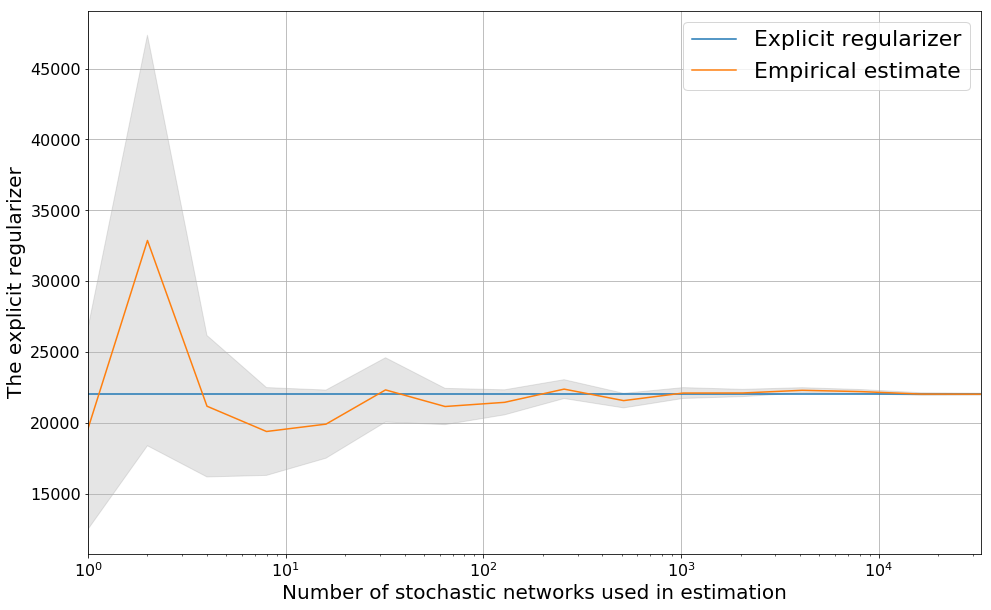

In [4]:
# first, specify the architecture of the network
d=[5,5,5,5,5,5]

# 1 - theta = .5 is a standard dropout rate
theta = .5

# Generate a random second moment with exponential decay in the expectrum
# L=torch.randn(d[0],d[0])
# sqrt_C=L@L.t()
# sqrt_C=sqrt_C / torch.norm(sqrt_C)
# Uncomment if you want the distribution to be isotropic 
sqrt_C = torch.eye(d[0])

iters = 50 # number of iterations the whole experiment is repeated
samples = 19 # 2**samples is the maximum number of stochastic networks sampled from w

path = "page/estimate"
try:  
    if not os.path.exists(path):
        os.makedirs(path)
except OSError:  
    print ("Creation of the directory %s failed" % path)

file_name = "%s/arch=%s,theta=%.4f.npz" %(path,d,theta)
if not os.path.exists(file_name):
    # let's build a network by appending random weights to it
    w=[]
    for width in range(len(d)-1):
        w.append(torch.rand(d[width+1],d[width]))

    # call the explicit_regularizer(), the function that implements the explicit regularizer as derived in the paper
    reg,_,_ = explicit_regularizer(w,.5,sqrt_C)
    true_reg = sum(reg)

    est = torch.zeros(samples,iters) # keeps the estimated regularizer
    for j in range(iters):
        for i in range(samples):
            est[i,j] = estimated_regularizer(w,theta,2**i,sqrt_C)

    est_std = np.std(est.numpy(),1)/5
    est_mean = np.mean(est.numpy(),1)
    np.savez(file_name, est_std=est_std, est_mean=est_mean, true_reg=true_reg, samples=samples)
else:
    data = np.load(file_name)
    est_std, est_mean, true_reg, samples = data['est_std'], data['est_mean'], data['true_reg'], data['samples']
    print('Loaded the model from file.')


plt.close()
plt.figure(figsize=(16,10))

plt.plot([2**i for i in range(samples)],np.ones(samples)*true_reg,label="Explicit regularizer")
plt.plot([2**i for i in range(samples)],est_mean,label="Empirical estimate")
plt.fill_between([2**i for i in range(samples)],est_mean-est_std,est_mean+est_std,color='gray', alpha=0.2)

plt.legend(prop={'size': 22})

plt.xlabel("Number of stochastic networks used in estimation", fontsize=20)
plt.ylabel('The explicit regularizer', fontsize=20)
# plt.title('Verifying the closed form of the regularizer')

# plt.yscale('log')
plt.xscale('log')
plt.xlim((1,2**(samples-4)))
plt.grid()
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

try:  
    if not os.path.exists("plots"):
        os.makedirs("plots")
except OSError:  
    print ("Creation of the plots directory failed")


plt.savefig("plots/explicit_regularizer.pdf", bbox_inches='tight')
plt.show()

# Solving the convex envelope to get a lower bound on the excess risk
We show in the appendix that the global minimizer of $\min_{\mathrm{M}} L(\mathrm{M}) + \Theta^{**}(\mathrm{M})$ is given in terms of a specific shrinkage-thresholding on the spectrum of the matrix $\mathrm{C}_{\mathrm{y}\mathrm{x}}\mathrm{C}^{-\frac12}$. cvx_lb_sol() implements this shrinkage-thresholding operator.

In [5]:
def cvx_lb_sol(true_model, d_min, nu):
    """ the solution to the convex lowerbound, min_M L(M) + \Theta^{**}(M).
    
    Args:
        true_model:   C_yx * C^{-0.5}
        d_min:   architecture bottleneck
        nu: the network complexity 
        
    Returns:
        soln: global optimum of min_M L(M) + \Theta^{**}(M)
    """
    
    U, sv, V = np.linalg.svd(true_model, full_matrices=False) # SVD of the true_model
    pos_idx = sv>0 # only concerned about positive singular values
    sv, U, V = sv[pos_idx], U[:,pos_idx], V[pos_idx,:] # restrict the SVD to positive singular values
    rank_true_model = sv.shape[0] # rank of the true_model
    r = min(rank_true_model, d_min) # maximum rank of the solution
    sv, U, V = sv[range(r)], U[:,range(r)], V[range(r),:].T
    for rho in reversed(range(1,r+1)):
        kappa_rho = np.sum(sv[0:rho])
        alpha_rho = (nu*kappa_rho) / (1 + nu*rho)
        if sv[rho-1] > alpha_rho:
            sv = sv - alpha_rho
            sv[sv<=0] = 0
            soln = U @ np.diag(sv) @ V.T
            return soln;

## Define the class of deep linear networks with dropout layers

In [6]:
class DLN(torch.nn.Module):
    def __init__(self, d, theta):
        super(DLN, self).__init__()
        self.module_list = torch.nn.ModuleList()
        k = len(d)-1
        for i in range(k-1):
            self.module_list.append(torch.nn.Linear(d[i], d[i+1], bias="False"))
            stdv = 1. / np.sqrt(d[i]*d[i+1])
            self.module_list[2*i].weight.data.uniform_(-stdv, stdv)
            self.module_list.append(torch.nn.Dropout(p=1-theta))
            
        self.module_list.append(torch.nn.Linear(d[k-1], d[k], bias="False"))
        stdv = 1. / np.sqrt(d[k-1]*d[k])
        self.module_list[2*k-2].weight.data.uniform_(-stdv, stdv)
        
    def forward(self, x):
        for layer in self.module_list:
            x = layer(x)
        return x

In [7]:
def net_flow(d, theta):
    """ computes the network complexity for a network with architecture "d" and dropout rate 1-theta
    
    Args:
        d:      the architecture
        theta:  the Bernouli parameter, = 1 - dropout rate
    Returns:
        sub_flow:   the network complexity
    """
    
    lam = (1-theta)/theta # lambda, the "regularization parameter"

    k = len(d)-1 # k-1 is the number of hidden layers
    sub_flow = np.zeros(k-1) # array of the sub-flows, each entry corresponds to a pivot lentgth

    for l in range(1,k): # generate the set of all possible pivot layers
        pivot_set = list(combinations(range(1,k), l)) # contains all possible pivots of length l

        sub_flow[l-1] = 0 # the sum of it elemetns gives the network complexity
        for pivots in pivot_set: # "pivots" keep a combination of hidden layers (= pivot) of length l
            prod = 1 # initialize the product with one
            for pivot in pivots: # "pivot" iterates over the the hiddel layers in "pivots"
                prod = prod * d[pivot]
            
            sub_flow[l-1] = sub_flow[l-1] + (lam**l) / prod # this is how the "network complexity" is calculated

    return sub_flow

In [8]:
def train_step(model, optimizer, true_model, batch_size, sqrt_C):
    """ train a DLN "model" using "optimizer" with a minibatch of size "batch_size"
    
    Args:
        model:      the network to be trained
        optimizer:  the optimiziation method
        true_model: the model that generates the labels
        batch_size: the size of the minibatch
        sqrt_C:     the principal square root of the second moment C := E[x x']
    Returns:
        loss.data[0]:   the training loss at the current iterate
    """
  
    model.train()
    
    d_in = model.module_list[0].weight.data.shape[1]
    
    # sample a minibatch of size batch_size from Gaussian distribution with mean zero and covariance C:=sqrt_C^2
    input_batch = Variable(torch.randn(batch_size, d_in) @ sqrt_C)
    output_batch = model(input_batch) # evaluate the model
    label_batch = input_batch@true_model.t() # the true labels

    # mean squared loss
    loss = F.mse_loss(output_batch, label_batch, size_average=True)  
    model.zero_grad()     
    loss.backward()     
    optimizer.step()
    
    return loss.data[0]

In [9]:
def val(model, theta, true_model, d,sqrt_C):
    """ evaluates the test error as well as the explicit regularizer of a DLN "model"
    
    Args:
        model:      the network to be trained
        theta:      1 - dropout rate
        true_model: the model that generates the labels
        d:          the architecture of the network
        sqrt_C:     the principal square root of the second moment C := E[x x']
    Returns:
        loss: the population risk, L({ W_i })
        reg:   the array of sub-regularizers
        lb:    the array of the corresponding lower bounds on sub-regularizers
        sv:    the singular values of the network map
    """
    
    model.eval()
            
    Ws = [] # the "implementation" of the current "network map" stored in "model"
    wk0 = torch.eye(d[0]) # the network map
    k = len(d)-1 # k-1 is the number of hidden layers
    for i in range(k):
        Ws.append(model.module_list[2*i].weight.data)
        wk0 = Ws[i] @ wk0
                
    loss = torch.norm((true_model - wk0)@sqrt_C.type_as(true_model - wk0))**2
    reg, lb, sv = explicit_regularizer(Ws, theta, sqrt_C) 
    
    return loss, reg, lb, sv


In [10]:
def dropout_training(thetas,lrs,d,rk,noise_level,iters, sqrt_C):
    """ training with dropout rates list in 1-thetas, in a network with architecture d,
    learning rates list in lrs, and iterations list in iters
    
    Args:
        thetas: list of 1 - dropout rates. EX: [.4,.7]
        d: network architecture. d[0]/d[-1] corresponds to  input/output dimensionality. EX: [3,5,7,2]
        rk: (effective) rank of the true model
        noise_level: additional noise added to the true model
        lrs: list of learning rates. EX: [.3, 30]
        iters: list of iteration numbers. EX: np.arange(10)
        sqrt_C:     the principal square root of the second moment C := E[x x']        
    Saves:
        risk: population risk, L({ \W_i })
        sub_regs: the array of the sub-regularizers,
        lbs: the corresponding lower bounds on the sub-regularizers,
        svs: singular values of the network maps at the validation time
        env_risk : the risk achieved by the convex lowerbound solution
        dist_opt : distance to the convex lowerbound solution
    """
    
    rk=min(rk,d[0],d[-1])
    path = "page/true_model"
    try:  
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:  
        print ("Creation of the directory %s failed" % path)
    
    file_name = "%s/d_in=%d,d_out=%d,rank=%d,noise_level=%.4f.npz" %(path,d[0],d[-1],rk,noise_level)
    if not os.path.exists(file_name):
        m = np.random.randn(d[-1], rk) @ np.random.randn(rk, d[0]) + noise_level * np.random.randn(d[-1], d[0])
        np.savez(file_name, m=m)
        print ("Successfully created the true model")
    else:
        data = np.load(file_name)
        m = data['m']
        print('Loaded the model from file.')
    M = Variable(torch.Tensor(m), requires_grad=False)


    
    for theta in thetas:
        lam = (1-theta)/theta

        inv_sqrt_C = np.linalg.inv(sqrt_C)
        nu = np.sum(net_flow(d,theta))
        sol = cvx_lb_sol(m @ inv_sqrt_C, np.min(d), nu) @ inv_sqrt_C

        for lr0 in lrs:
            path = "page/theta=%.2f/d=%s/rank=%d/noise_level=%.4f/lr=%.2f" %(theta,d,rk,noise_level,lr0)

            try:  
                if not os.path.exists(path):
                    os.makedirs(path)
                    print ("Successfully created the directory %s " % path)
#                 else:
#                     print('Directory already exists.')
            except OSError:  
                print ("Creation of the directory %s failed" % path)

            for itr in iters:
                lr = lr0
                file_name = '%s/iter=%d.npz'%(path,itr)
                model_name = '%s/iter=%d.pt'%(path,itr)
                if not os.path.exists(file_name):
                    torch.manual_seed(itr)
                    model = DLN(d, theta)
    
                    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
                    info = []

                    for step in range(NUM_STEPS):
                        if step % 10000 == 0:
                            lr = lr/1.4
                            for param_group in optimizer.param_groups:
                                param_group['lr'] = lr

                        train_loss = train_step(model,optimizer,M,MBSIZE,sqrt_C)
                        # [0,1,2,4,8,...,512,1000,2000,...,10000,12000,...,40000,45000,50000]
                        val_index_set = [2**i for i in range(10)]+[1000*i for i in range(11)]+[2000*i for i in range(6,21)]+[5000*i for i in range(8,11)]

                        if step in val_index_set:
                            loss, reg, lb, sv = val(model,theta,m,d,sqrt_C)
                            normalized_gap = reg/lb - 1
                                                        
                            net_map = torch.eye(d[0]) # the network map
                            num_layers = len(d)-1 # num_layers is the number of layers
                            for layer in range(num_layers):
                                net_map = model.module_list[2*layer].weight.data @ net_map

                            envelope_risk = np.linalg.norm((m - sol)@sqrt_C)**2 # the risk achieved by the convex lowerbound solution
                            dist_to_cvx_lb = np.linalg.norm((net_map.numpy() - sol)@sqrt_C)**2 # distance to the convex lowerbound solution

                            print('Itr {:5d}: risk {:.3f}, risk of truth {:.3f}, dist to truth {:.3f}, norm gap {:.4f}.'.format(step, loss, envelope_risk, dist_to_cvx_lb, np.linalg.norm(normalized_gap)))
                            info.append([step, loss, reg, lb, sv, envelope_risk, dist_to_cvx_lb])

                    steps, risk, sub_regs, lbs, svs, env_risk, dist_opt = zip(*info)
                    torch.save(model,model_name)
                    np.savez(file_name, steps = steps, risk = risk, sub_regs = sub_regs, lbs = lbs, svs = svs, env_risk = env_risk, dist_opt = dist_opt)
#                 else:
#                     print('%s already exists'%file_name)


## Experiments part 1: does dropout training perform spectral shrinkage-thresholding like nuclear norm regularization?
First, we train a network with architecture $\{ d_i \} = (20,20,20,20)$ with different values of the dropout rate.

In [14]:
rk ,noise_level = 15, .1
MBSIZE, NUM_STEPS = 1000, 16010


ds=[[20, 20, 20, 20]]
thetas,lrs,iters = [.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1], [.01], range(41)



for d in ds:
##  Generate a random second moment with exponential decay in the expectrum
#     L=torch.randn(d[0],d[0])
#     sqrt_C=L@L.t()
#     sqrt_C=sqrt_C / torch.norm(sqrt_C)
##  Or uncomment if you want the distribution to be isotropic 
    sqrt_C = torch.eye(d[0])

    dropout_training(thetas,lrs,d,rk,noise_level,iters,sqrt_C)

Loaded the model from file.
Itr     0: risk 6334.646, risk of truth 4803.212, dist to truth 217.621, norm gap 44.9616.
Itr     1: risk 6334.639, risk of truth 4803.212, dist to truth 217.620, norm gap 44.9636.
Itr     2: risk 6334.631, risk of truth 4803.212, dist to truth 217.620, norm gap 45.1089.
Itr     4: risk 6334.618, risk of truth 4803.212, dist to truth 217.618, norm gap 45.1814.
Itr     8: risk 6334.591, risk of truth 4803.212, dist to truth 217.615, norm gap 45.2561.
Itr    16: risk 6334.539, risk of truth 4803.212, dist to truth 217.609, norm gap 45.1457.
Itr    32: risk 6334.439, risk of truth 4803.212, dist to truth 217.596, norm gap 44.2787.
Itr    64: risk 6334.222, risk of truth 4803.212, dist to truth 217.567, norm gap 41.3798.
Itr   128: risk 6333.556, risk of truth 4803.212, dist to truth 217.469, norm gap 30.3762.
Itr   256: risk 6320.597, risk of truth 4803.212, dist to truth 214.873, norm gap 8.4633.
Itr   512: risk 5236.899, risk of truth 4803.212, dist to truth

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type DLN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Itr    32: risk 6334.436, risk of truth 4155.277, dist to truth 392.085, norm gap 44.4108.
Itr    64: risk 6334.208, risk of truth 4155.277, dist to truth 392.040, norm gap 41.3415.
Itr   128: risk 6333.530, risk of truth 4155.277, dist to truth 391.895, norm gap 30.2029.
Itr   256: risk 6319.358, risk of truth 4155.277, dist to truth 387.978, norm gap 8.2456.
Itr   512: risk 5076.099, risk of truth 4155.277, dist to truth 263.509, norm gap 0.1165.
Itr  1000: risk 5068.779, risk of truth 4155.277, dist to truth 260.589, norm gap 0.0395.
Itr  2000: risk 5071.428, risk of truth 4155.277, dist to truth 258.802, norm gap 0.0444.
Itr  3000: risk 5081.516, risk of truth 4155.277, dist to truth 253.009, norm gap 0.0472.
Itr  4000: risk 5083.046, risk of truth 4155.277, dist to truth 252.095, norm gap 0.0442.
Itr  5000: risk 5080.018, risk of truth 4155.277, dist to truth 253.652, norm gap 0.0424.
Itr  6000: risk 5108.720, risk of truth 4155.277, dist to truth 239.143, norm gap 0.0450.
Itr  70

Itr    64: risk 6334.208, risk of truth 2409.371, dist to truth 1345.870, norm gap 41.4264.
Itr   128: risk 6333.524, risk of truth 2409.371, dist to truth 1345.570, norm gap 30.2783.
Itr   256: risk 6317.933, risk of truth 2409.371, dist to truth 1337.511, norm gap 8.1378.
Itr   512: risk 3921.984, risk of truth 2409.371, dist to truth 542.257, norm gap 1.3743.
Itr  1000: risk 3887.255, risk of truth 2409.371, dist to truth 540.342, norm gap 1.1725.
Itr  2000: risk 3214.002, risk of truth 2409.371, dist to truth 236.018, norm gap 2.0088.
Itr  3000: risk 3217.863, risk of truth 2409.371, dist to truth 235.837, norm gap 2.0115.
Itr  4000: risk 3177.895, risk of truth 2409.371, dist to truth 242.266, norm gap 2.0091.
Itr  5000: risk 3219.495, risk of truth 2409.371, dist to truth 235.347, norm gap 2.0114.
Itr  6000: risk 3201.711, risk of truth 2409.371, dist to truth 238.022, norm gap 2.0067.
Itr  7000: risk 3213.755, risk of truth 2409.371, dist to truth 236.185, norm gap 2.0085.
Itr  

Itr    64: risk 6334.206, risk of truth 1240.919, dist to truth 2423.855, norm gap 41.3234.
Itr   128: risk 6333.516, risk of truth 1240.919, dist to truth 2423.432, norm gap 30.1424.
Itr   256: risk 6317.592, risk of truth 1240.919, dist to truth 2412.669, norm gap 8.1066.
Itr   512: risk 3710.001, risk of truth 1240.919, dist to truth 1105.286, norm gap 1.6794.
Itr  1000: risk 2202.352, risk of truth 1240.919, dist to truth 356.109, norm gap 3.0158.
Itr  2000: risk 2205.634, risk of truth 1240.919, dist to truth 354.462, norm gap 2.9939.
Itr  3000: risk 2217.731, risk of truth 1240.919, dist to truth 351.617, norm gap 2.9943.
Itr  4000: risk 2200.373, risk of truth 1240.919, dist to truth 355.501, norm gap 2.9989.
Itr  5000: risk 2222.066, risk of truth 1240.919, dist to truth 350.491, norm gap 2.9969.
Itr  6000: risk 2209.700, risk of truth 1240.919, dist to truth 353.001, norm gap 2.9973.
Itr  7000: risk 2213.804, risk of truth 1240.919, dist to truth 352.070, norm gap 2.9944.
Itr 

Itr    64: risk 6334.204, risk of truth 442.317, dist to truth 3825.763, norm gap 41.2861.
Itr   128: risk 6333.514, risk of truth 442.317, dist to truth 3825.224, norm gap 30.1131.
Itr   256: risk 6317.127, risk of truth 442.317, dist to truth 3811.805, norm gap 8.0926.
Itr   512: risk 3339.005, risk of truth 442.317, dist to truth 1692.039, norm gap 2.6597.
Itr  1000: risk 1895.035, risk of truth 442.317, dist to truth 769.685, norm gap 3.4229.
Itr  2000: risk 1374.173, risk of truth 442.317, dist to truth 445.771, norm gap 4.0069.
Itr  3000: risk 1378.815, risk of truth 442.317, dist to truth 444.825, norm gap 4.0014.
Itr  4000: risk 1373.983, risk of truth 442.317, dist to truth 445.879, norm gap 4.0011.
Itr  5000: risk 1375.806, risk of truth 442.317, dist to truth 445.441, norm gap 4.0007.
Itr  6000: risk 1379.132, risk of truth 442.317, dist to truth 444.337, norm gap 3.9973.
Itr  7000: risk 1371.123, risk of truth 442.317, dist to truth 446.977, norm gap 3.9957.
Itr  8000: risk

Itr    64: risk 6334.206, risk of truth 23.337, dist to truth 5726.807, norm gap 41.2838.
Itr   128: risk 6333.514, risk of truth 23.337, dist to truth 5726.147, norm gap 30.0870.
Itr   256: risk 6317.122, risk of truth 23.337, dist to truth 5710.381, norm gap 8.1136.
Itr   512: risk 2609.749, risk of truth 23.337, dist to truth 2251.372, norm gap 4.5750.
Itr  1000: risk 869.108, risk of truth 23.337, dist to truth 688.693, norm gap 6.2297.
Itr  2000: risk 286.323, risk of truth 23.337, dist to truth 198.936, norm gap 8.0588.
Itr  3000: risk 140.984, risk of truth 23.337, dist to truth 79.561, norm gap 8.9531.
Itr  4000: risk 140.161, risk of truth 23.337, dist to truth 79.624, norm gap 8.9645.
Itr  5000: risk 140.424, risk of truth 23.337, dist to truth 79.600, norm gap 8.9690.
Itr  6000: risk 140.390, risk of truth 23.337, dist to truth 79.558, norm gap 8.9685.
Itr  7000: risk 140.023, risk of truth 23.337, dist to truth 79.632, norm gap 8.9622.
Itr  8000: risk 140.781, risk of truth

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


Itr    64: risk 6334.201, risk of truth 0.000, dist to truth 6334.201, norm gap nan.
Itr   128: risk 6333.501, risk of truth 0.000, dist to truth 6333.501, norm gap nan.
Itr   256: risk 6316.394, risk of truth 0.000, dist to truth 6316.394, norm gap nan.
Itr   512: risk 2554.311, risk of truth 0.000, dist to truth 2554.311, norm gap nan.
Itr  1000: risk 621.266, risk of truth 0.000, dist to truth 621.266, norm gap nan.
Itr  2000: risk 121.350, risk of truth 0.000, dist to truth 121.350, norm gap nan.
Itr  3000: risk 54.990, risk of truth 0.000, dist to truth 54.990, norm gap nan.
Itr  4000: risk 26.642, risk of truth 0.000, dist to truth 26.642, norm gap nan.
Itr  5000: risk 26.239, risk of truth 0.000, dist to truth 26.239, norm gap nan.
Itr  6000: risk 7.717, risk of truth 0.000, dist to truth 7.717, norm gap nan.
Itr  7000: risk 2.149, risk of truth 0.000, dist to truth 2.149, norm gap nan.
Itr  8000: risk 1.790, risk of truth 0.000, dist to truth 1.790, norm gap nan.
Itr  9000: ris

We plot the distribution of the singular values of the trained network for different values of the dropout rate (i.e. $1 - \theta$). The vertical axis is the singular value and the horizontal axis is its respective index. Each curve corresponds to a value of the dropout rate.

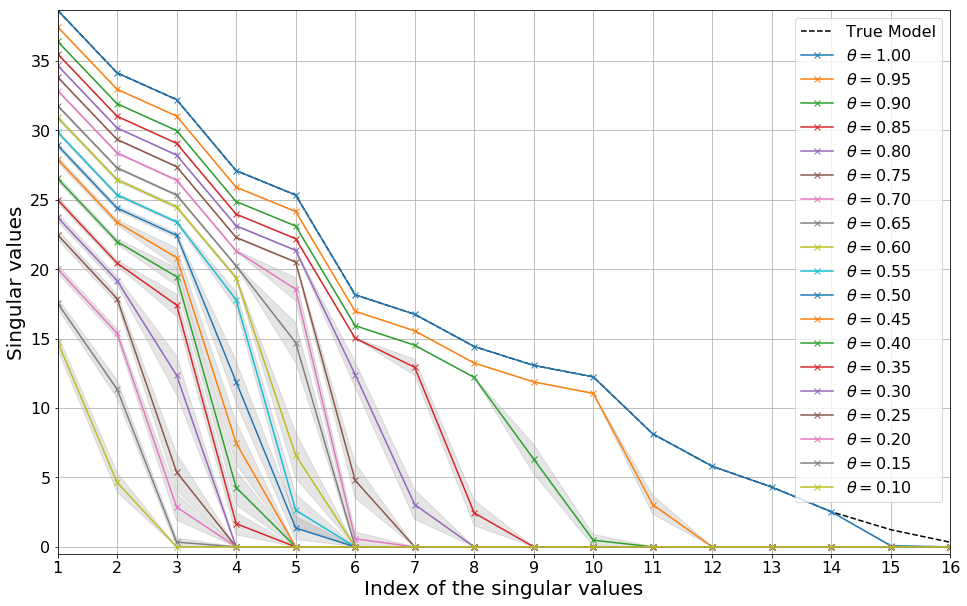

In [15]:
d=ds[0]
num_iters = len(iters)
singulars = np.zeros((d[0], num_iters, len(thetas)))

for idx in range(len(thetas)):
    for itr in iters:
        file_name = "page/theta=%.2f/d=%s/rank=%d/noise_level=%.4f/lr=%.2f/iter=%d.npz" %(thetas[idx],d,rk,noise_level,lrs[0],itr)
        data = np.load(file_name)
        svs = data['svs']
        singulars[:,itr,idx] = svs[-1,:]

svs_std = np.std(singulars,1)/5
svs_avg = np.mean(singulars,1)

true_model_name = "page/true_model/d_in=%d,d_out=%d,rank=%d,noise_level=%.4f.npz"%(d[0],d[-1],rk,noise_level)
true_model = np.load(true_model_name)
m = true_model['m']
_, sv, _ = np.linalg.svd(m)

plt.close()
plt.figure(figsize=(16,10))

plt.plot(np.arange(d[0])+1,sv,color='black', linestyle='dashed',label="True Model")

for idx in reversed(range(len(thetas))):
    plt.plot(np.arange(d[0])+1,svs_avg[:,idx], marker='x', label=r"$\theta = %.2f$"%thetas[idx])
    plt.fill_between(np.arange(d[0])+1,svs_avg[:,idx]-svs_std[:,idx],svs_avg[:,idx]+svs_std[:,idx],color='gray', alpha=0.2)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.xticks(np.arange(d[0])+1) 
plt.xlim((1,16))
plt.ylim((-.5,sv[0]))
plt.legend(prop={'size': 16})
plt.xlabel('Index of the singular values', fontsize=20)
plt.ylabel('Singular values', fontsize=20)
# plt.title('The distribution of the singular values of the trained network', fontsize=20)
# plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.savefig("plots/svs_architecture=%s.pdf"%d, bbox_inches='tight')
plt.show()

## Experiments part 2: Does the regularizer achieve its lower bound?
We train a network with architecture $\{ d_i \} = (5, 5, 5, 5, 5, 5, 1)$, for a fixed value of the dropout rate (i.e. $1-\theta$, for $\theta=0.7$).

In [17]:
MBSIZE, NUM_STEPS = 1000, 40010
rk ,noise_level = 1, .1

ds=[[5, 5, 5, 5, 5, 5, 1]]

thetas, lrs, iters = [.7], [.3], range(31)

for d in ds:
##  Generate a random second moment with exponential decay in the expectrum
#     L=torch.randn(d[0],d[0])
#     sqrt_C=L@L.t()
#     sqrt_C=sqrt_C / torch.norm(sqrt_C)
##  Or uncomment if you want the distribution to be isotropic 
    sqrt_C = torch.eye(d[0])

    dropout_training(thetas,lrs,d,rk,noise_level,iters,sqrt_C)

Loaded the model from file.
Itr     0: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 868.2453.
Itr     1: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 894.6636.
Itr     2: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 910.9353.
Itr     4: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 921.5970.
Itr     8: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 973.6093.
Itr    16: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 1065.2326.
Itr    32: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 1142.0408.
Itr    64: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 1300.2429.
Itr   128: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 1463.7732.
Itr   256: risk 0.065, risk of truth 0.007, dist to truth 0.029, norm gap 932.1279.
Itr   512: risk 0.065, risk of truth 0.007, dist to truth 0.028, norm gap 249.3041.
Itr  1000: risk 0.015, risk of truth 0.007, 

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type DLN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


We compare the values of the sub-regularizers of the individual iterates with their respective lower bounds. To that end, we define the normalized gap, $r_\ell(t) := \frac{R_\ell(\{ \mathrm{W}_i^{(t)} \}) - {LB}_\ell(\{ \mathrm{W}_i^{(t)} \})}{{LB}_\ell(\{ \mathrm{W}_i^{(t)} \})}$, where $R_\ell$ and ${LB}_\ell$ denote the $\ell$-th sub-regularizer and its lower bound respectively.

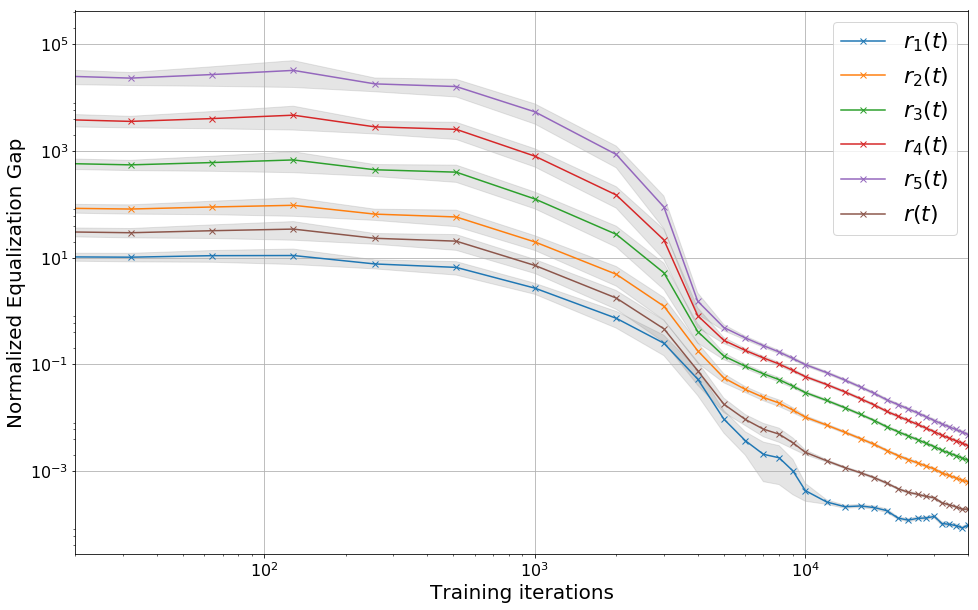

In [18]:
num_iters = len(iters)
theta=thetas[0]
d=ds[0]
rk=min(rk,d[0],d[-1])
file_name = "page/theta=%.2f/d=%s/rank=%d/noise_level=%.4f/lr=%.2f/iter=%d.npz" %(theta,d,rk,noise_level,lrs[0],0)
data = np.load(file_name)
sub_regs= data['sub_regs']
[samples, num_sub_regs] = sub_regs.shape

normal_gaps = np.zeros((samples, num_sub_regs, num_iters))
total_gap = np.zeros((samples, num_iters))

for itr in iters:
    file_name = "page/theta=%.2f/d=%s/rank=%d/noise_level=%.4f/lr=%.2f/iter=%d.npz" %(theta,d,rk,noise_level,lrs[0],itr)
    data = np.load(file_name)
    steps, sub_regs, lbs = data['steps'],data['sub_regs'],data['lbs']
    normal_gaps[:,:,itr] = sub_regs/lbs - 1
    total_gap[:,itr] = (np.sum(sub_regs, axis=1) / np.sum(lbs, axis=1)) - 1

normal_gaps_std = np.std(normal_gaps,2)/6
normal_gaps_avg = np.mean(normal_gaps,2)

total_gap_std = np.std(total_gap,1)/6
total_gap_avg = np.mean(total_gap,1)

plt.close()
plt.figure(figsize=(16,10))
for idx in range(num_sub_regs):
    plt.plot(steps,normal_gaps_avg[:,idx],marker='x',label=r"$r_%d(t)$"%(idx+1))
    plt.fill_between(steps,normal_gaps_avg[:,idx]-normal_gaps_std[:,idx],normal_gaps_avg[:,idx]+normal_gaps_std[:,idx],color='gray', alpha=0.2)
    
plt.plot(steps,total_gap_avg,marker='x', label=r"$r(t)$")
plt.fill_between(steps,total_gap_avg-total_gap_std,total_gap_avg+total_gap_std,color='gray', alpha=0.2)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.legend(prop={'size': 22})
plt.xlabel('Training iterations', fontsize=20)
plt.ylabel('Normalized Equalization Gap', fontsize=20)
# plt.title('convergence of sub-regularizers')

plt.yscale('log')
plt.xscale('log')
plt.xlim((20,steps[-1]))

plt.grid()
plt.savefig("plots/normalized_gaps_%s.pdf"%d, bbox_inches='tight')
plt.show()


## Experiments part 3: How does the population risk $L(\{\mathrm{W}_i\})$ depend on the network complexity?
First, let's train some networks with different architectures, where we keep the depth fixed, and increase the width of the hidden layers  (specified in $ds$, which is a list of desired architectures), and for different values of the dropout rate  (i.e. $1-\theta$, for $\theta \in \{.3,.5,.8 \}$).

In [20]:
MBSIZE, NUM_STEPS = 1000, 12010
rk ,noise_level = 1, .1
NUM_WIDTH = [10,20,30,40,50,60,80,100]

ds=[[10, i, i, 1] for i in NUM_WIDTH]

net_size=np.array([sum([d[i]*d[i+1] for i in range(len(d)-1)]) for d in ds])

thetas,lrs,iters = [.55,.6,.65,.7,.725,.75,.775,.8,.82,.84,.86,.88], [.1], range(21)



for d in ds:
##  Generate a random second moment with exponential decay in the expectrum
#     L=torch.randn(d[0],d[0])
#     sqrt_C=L@L.t()
#     sqrt_C=sqrt_C / torch.norm(sqrt_C)
##  Or uncomment if you want the distribution to be isotropic 
    sqrt_C = torch.eye(d[0])

    dropout_training(thetas,lrs,d,rk,noise_level,iters,sqrt_C)

Loaded the model from file.
Itr     0: risk 0.826, risk of truth 0.018, dist to truth 0.602, norm gap 117.7916.
Itr     1: risk 0.824, risk of truth 0.018, dist to truth 0.600, norm gap 104.7120.
Itr     2: risk 0.822, risk of truth 0.018, dist to truth 0.599, norm gap 92.0929.
Itr     4: risk 0.818, risk of truth 0.018, dist to truth 0.595, norm gap 70.1538.
Itr     8: risk 0.807, risk of truth 0.018, dist to truth 0.585, norm gap 42.6209.
Itr    16: risk 0.760, risk of truth 0.018, dist to truth 0.546, norm gap 17.6876.
Itr    32: risk 0.304, risk of truth 0.018, dist to truth 0.176, norm gap 5.8368.
Itr    64: risk 0.055, risk of truth 0.018, dist to truth 0.010, norm gap 2.0815.
Itr   128: risk 0.027, risk of truth 0.018, dist to truth 0.001, norm gap 0.9565.
Itr   256: risk 0.023, risk of truth 0.018, dist to truth 0.000, norm gap 0.4404.
Itr   512: risk 0.017, risk of truth 0.018, dist to truth 0.000, norm gap 0.2238.
Itr  1000: risk 0.014, risk of truth 0.018, dist to truth 0.00

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type DLN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Itr   128: risk 0.021, risk of truth 0.012, dist to truth 0.001, norm gap 1.0933.
Itr   256: risk 0.017, risk of truth 0.012, dist to truth 0.000, norm gap 0.5247.
Itr   512: risk 0.014, risk of truth 0.012, dist to truth 0.000, norm gap 0.2839.
Itr  1000: risk 0.010, risk of truth 0.012, dist to truth 0.000, norm gap 0.1600.
Itr  2000: risk 0.015, risk of truth 0.012, dist to truth 0.000, norm gap 0.0640.
Itr  3000: risk 0.012, risk of truth 0.012, dist to truth 0.000, norm gap 0.0269.
Itr  4000: risk 0.013, risk of truth 0.012, dist to truth 0.000, norm gap 0.0135.
Itr  5000: risk 0.011, risk of truth 0.012, dist to truth 0.000, norm gap 0.0091.
Itr  6000: risk 0.014, risk of truth 0.012, dist to truth 0.000, norm gap 0.0054.
Itr  7000: risk 0.009, risk of truth 0.012, dist to truth 0.000, norm gap 0.0039.
Itr  8000: risk 0.013, risk of truth 0.012, dist to truth 0.000, norm gap 0.0032.
Itr  9000: risk 0.012, risk of truth 0.012, dist to truth 0.000, norm gap 0.0031.
Itr 10000: risk 

Itr 10000: risk 0.003, risk of truth 0.003, dist to truth 0.000, norm gap 0.0308.
Itr 12000: risk 0.003, risk of truth 0.003, dist to truth 0.000, norm gap 0.0224.
Itr     0: risk 0.826, risk of truth 0.003, dist to truth 0.737, norm gap 116.3134.
Itr     1: risk 0.824, risk of truth 0.003, dist to truth 0.735, norm gap 103.5592.
Itr     2: risk 0.822, risk of truth 0.003, dist to truth 0.733, norm gap 91.5989.
Itr     4: risk 0.818, risk of truth 0.003, dist to truth 0.728, norm gap 69.9319.
Itr     8: risk 0.806, risk of truth 0.003, dist to truth 0.717, norm gap 41.4467.
Itr    16: risk 0.752, risk of truth 0.003, dist to truth 0.666, norm gap 16.4988.
Itr    32: risk 0.171, risk of truth 0.003, dist to truth 0.132, norm gap 5.8447.
Itr    64: risk 0.011, risk of truth 0.003, dist to truth 0.003, norm gap 3.0678.
Itr   128: risk 0.006, risk of truth 0.003, dist to truth 0.001, norm gap 1.7232.
Itr   256: risk 0.004, risk of truth 0.003, dist to truth 0.000, norm gap 0.9644.
Itr   51

Itr   512: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.8025.
Itr  1000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.5072.
Itr  2000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.3846.
Itr  3000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.3461.
Itr  4000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.3168.
Itr  5000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.2940.
Itr  6000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.2698.
Itr  7000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.2444.
Itr  8000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.2276.
Itr  9000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.2101.
Itr 10000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.1961.
Itr 12000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.1776.
Itr     0: risk 

Itr    64: risk 0.004, risk of truth 0.001, dist to truth 0.001, norm gap 2.2961.
Itr   128: risk 0.003, risk of truth 0.001, dist to truth 0.000, norm gap 1.5097.
Itr   256: risk 0.002, risk of truth 0.001, dist to truth 0.000, norm gap 0.9419.
Itr   512: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.6311.
Itr  1000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.4861.
Itr  2000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.3771.
Itr  3000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.3167.
Itr  4000: risk 0.002, risk of truth 0.001, dist to truth 0.000, norm gap 0.2662.
Itr  5000: risk 0.002, risk of truth 0.001, dist to truth 0.000, norm gap 0.2263.
Itr  6000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.1955.
Itr  7000: risk 0.002, risk of truth 0.001, dist to truth 0.000, norm gap 0.1722.
Itr  8000: risk 0.002, risk of truth 0.001, dist to truth 0.000, norm gap 0.1499.
Itr  9000: risk 

Itr  9000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.3019.
Itr 10000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.2850.
Itr 12000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.2633.
Itr     0: risk 0.830, risk of truth 0.000, dist to truth 0.795, norm gap 272.6592.
Itr     1: risk 0.825, risk of truth 0.000, dist to truth 0.790, norm gap 218.0458.
Itr     2: risk 0.820, risk of truth 0.000, dist to truth 0.785, norm gap 171.8875.
Itr     4: risk 0.809, risk of truth 0.000, dist to truth 0.774, norm gap 101.9344.
Itr     8: risk 0.776, risk of truth 0.000, dist to truth 0.742, norm gap 37.3420.
Itr    16: risk 0.607, risk of truth 0.000, dist to truth 0.577, norm gap 8.0261.
Itr    32: risk 0.004, risk of truth 0.000, dist to truth 0.002, norm gap 3.2118.
Itr    64: risk 0.002, risk of truth 0.000, dist to truth 0.000, norm gap 2.6917.
Itr   128: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 2.0170.
Itr   2

Itr   128: risk 0.006, risk of truth 0.002, dist to truth 0.001, norm gap 1.9041.
Itr   256: risk 0.003, risk of truth 0.002, dist to truth 0.000, norm gap 1.1910.
Itr   512: risk 0.004, risk of truth 0.002, dist to truth 0.000, norm gap 0.8209.
Itr  1000: risk 0.003, risk of truth 0.002, dist to truth 0.000, norm gap 0.6056.
Itr  2000: risk 0.002, risk of truth 0.002, dist to truth 0.000, norm gap 0.3996.
Itr  3000: risk 0.003, risk of truth 0.002, dist to truth 0.000, norm gap 0.2922.
Itr  4000: risk 0.002, risk of truth 0.002, dist to truth 0.000, norm gap 0.2125.
Itr  5000: risk 0.002, risk of truth 0.002, dist to truth 0.000, norm gap 0.1629.
Itr  6000: risk 0.003, risk of truth 0.002, dist to truth 0.000, norm gap 0.1291.
Itr  7000: risk 0.003, risk of truth 0.002, dist to truth 0.000, norm gap 0.1073.
Itr  8000: risk 0.002, risk of truth 0.002, dist to truth 0.000, norm gap 0.0885.
Itr  9000: risk 0.002, risk of truth 0.002, dist to truth 0.000, norm gap 0.0745.
Itr 10000: risk 

Itr 10000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.3216.
Itr 12000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.2921.
Itr     0: risk 0.841, risk of truth 0.000, dist to truth 0.804, norm gap 2560.0140.
Itr     1: risk 0.838, risk of truth 0.000, dist to truth 0.801, norm gap 3261.1845.
Itr     2: risk 0.835, risk of truth 0.000, dist to truth 0.798, norm gap 2507.6489.
Itr     4: risk 0.828, risk of truth 0.000, dist to truth 0.792, norm gap 747.9221.
Itr     8: risk 0.812, risk of truth 0.000, dist to truth 0.777, norm gap 164.5879.
Itr    16: risk 0.747, risk of truth 0.000, dist to truth 0.713, norm gap 26.0861.
Itr    32: risk 0.077, risk of truth 0.000, dist to truth 0.067, norm gap 5.6971.
Itr    64: risk 0.002, risk of truth 0.000, dist to truth 0.001, norm gap 4.1852.
Itr   128: risk 0.002, risk of truth 0.000, dist to truth 0.000, norm gap 2.9391.
Itr   256: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 1.9101.
It

Itr   512: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.6697.
Itr  1000: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 1.1611.
Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.8592.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.7558.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6991.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6683.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6412.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6278.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6096.
Itr  9000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.5936.
Itr 10000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.5749.
Itr 12000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.5639.
Itr     0: risk 

Itr 12000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.1952.
Itr     0: risk 0.837, risk of truth 0.001, dist to truth 0.793, norm gap 3494.4856.
Itr     1: risk 0.833, risk of truth 0.001, dist to truth 0.789, norm gap 1935.3437.
Itr     2: risk 0.829, risk of truth 0.001, dist to truth 0.785, norm gap 905.4056.
Itr     4: risk 0.822, risk of truth 0.001, dist to truth 0.779, norm gap 341.3863.
Itr     8: risk 0.804, risk of truth 0.001, dist to truth 0.762, norm gap 90.8988.
Itr    16: risk 0.728, risk of truth 0.001, dist to truth 0.687, norm gap 17.9491.
Itr    32: risk 0.062, risk of truth 0.001, dist to truth 0.050, norm gap 5.2650.
Itr    64: risk 0.003, risk of truth 0.001, dist to truth 0.001, norm gap 3.5716.
Itr   128: risk 0.003, risk of truth 0.001, dist to truth 0.001, norm gap 2.2259.
Itr   256: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 1.4149.
Itr   512: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 1.0054.
Itr 

Itr  1000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9896.
Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.8509.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.7529.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.7004.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6811.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6675.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6546.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6457.
Itr  9000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6281.
Itr 10000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6125.
Itr 12000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.5934.
Itr     0: risk 0.837, risk of truth 0.000, dist to truth 0.816, norm gap 3423.0577.
Itr     1: ri

Itr    16: risk 0.726, risk of truth 0.000, dist to truth 0.715, norm gap 17.6577.
Itr    32: risk 0.041, risk of truth 0.000, dist to truth 0.039, norm gap 5.3613.
Itr    64: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 4.6555.
Itr   128: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 3.8603.
Itr   256: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.8580.
Itr   512: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.9429.
Itr  1000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.3397.
Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0034.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9126.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.8700.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.8344.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.7967.
Itr  7000: risk

Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.7739.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.7519.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.7187.
Itr  9000: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 0.7076.
Itr 10000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6780.
Itr 12000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.6423.
Itr     0: risk 0.836, risk of truth 0.000, dist to truth 0.811, norm gap 2257.1042.
Itr     1: risk 0.833, risk of truth 0.000, dist to truth 0.808, norm gap 1583.0118.
Itr     2: risk 0.830, risk of truth 0.000, dist to truth 0.805, norm gap 1031.0000.
Itr     4: risk 0.824, risk of truth 0.000, dist to truth 0.799, norm gap 421.4964.
Itr     8: risk 0.808, risk of truth 0.000, dist to truth 0.783, norm gap 117.8299.
Itr    16: risk 0.736, risk of truth 0.000, dist to truth 0.712, norm gap 23.8242.
It

Itr    64: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 6.5944.
Itr   128: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 4.9060.
Itr   256: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 3.4836.
Itr   512: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.3908.
Itr  1000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.5983.
Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.1280.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9985.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9307.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9176.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9076.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9068.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9047.
Itr  9000: risk 

Itr  8000: risk 0.001, risk of truth 0.001, dist to truth 0.000, norm gap 0.4698.
Itr  9000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.4298.
Itr 10000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.3907.
Itr 12000: risk 0.000, risk of truth 0.001, dist to truth 0.000, norm gap 0.3408.
Itr     0: risk 0.839, risk of truth 0.000, dist to truth 0.803, norm gap 4656.7805.
Itr     1: risk 0.836, risk of truth 0.000, dist to truth 0.800, norm gap 5751.5956.
Itr     2: risk 0.832, risk of truth 0.000, dist to truth 0.796, norm gap 2923.2445.
Itr     4: risk 0.826, risk of truth 0.000, dist to truth 0.790, norm gap 890.3180.
Itr     8: risk 0.809, risk of truth 0.000, dist to truth 0.774, norm gap 172.0543.
Itr    16: risk 0.731, risk of truth 0.000, dist to truth 0.697, norm gap 23.6457.
Itr    32: risk 0.038, risk of truth 0.000, dist to truth 0.030, norm gap 5.7868.
Itr    64: risk 0.003, risk of truth 0.000, dist to truth 0.001, norm gap 4.3922.
It

Itr   128: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 3.9213.
Itr   256: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.9192.
Itr   512: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.0947.
Itr  1000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.5281.
Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2096.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0983.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0581.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0397.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0300.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0050.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9961.
Itr  9000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 0.9789.
Itr 10000: risk 

Itr 10000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.1106.
Itr 12000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.1109.
Itr     0: risk 0.839, risk of truth 0.000, dist to truth 0.830, norm gap 4698.9031.
Itr     1: risk 0.836, risk of truth 0.000, dist to truth 0.827, norm gap 5775.5029.
Itr     2: risk 0.833, risk of truth 0.000, dist to truth 0.824, norm gap 2951.3071.
Itr     4: risk 0.826, risk of truth 0.000, dist to truth 0.817, norm gap 884.4155.
Itr     8: risk 0.809, risk of truth 0.000, dist to truth 0.800, norm gap 172.1078.
Itr    16: risk 0.728, risk of truth 0.000, dist to truth 0.719, norm gap 23.1953.
Itr    32: risk 0.022, risk of truth 0.000, dist to truth 0.020, norm gap 6.0161.
Itr    64: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 5.3701.
Itr   128: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 4.6512.
Itr   256: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 3.7633.
It

Itr   256: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 2.8311.
Itr   512: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 2.1391.
Itr  1000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.6171.
Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.3558.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2681.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2226.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.1835.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.1617.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.1147.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0862.
Itr  9000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0492.
Itr 10000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.0311.
Itr 12000: risk 

Itr 12000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.3193.
Itr     0: risk 0.835, risk of truth 0.000, dist to truth 0.824, norm gap 4223.3482.
Itr     1: risk 0.832, risk of truth 0.000, dist to truth 0.822, norm gap 2332.0857.
Itr     2: risk 0.830, risk of truth 0.000, dist to truth 0.820, norm gap 1339.3451.
Itr     4: risk 0.825, risk of truth 0.000, dist to truth 0.815, norm gap 577.7070.
Itr     8: risk 0.811, risk of truth 0.000, dist to truth 0.801, norm gap 154.2677.
Itr    16: risk 0.752, risk of truth 0.000, dist to truth 0.743, norm gap 27.0863.
Itr    32: risk 0.077, risk of truth 0.000, dist to truth 0.074, norm gap 5.7675.
Itr    64: risk 0.001, risk of truth 0.000, dist to truth 0.000, norm gap 4.9188.
Itr   128: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 4.2413.
Itr   256: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 3.5132.
Itr   512: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.8255.
It

Itr  1000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.7299.
Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.0872.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.7882.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.6372.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.5415.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.4932.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.4545.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.4372.
Itr  9000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.4217.
Itr 10000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.4188.
Itr 12000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.4173.
Loaded the model from file.
Itr     0: risk 0.835, risk of truth 0.000, dist to truth 0.809, norm 

Itr     0: risk 0.835, risk of truth 0.000, dist to truth 0.823, norm gap 8695.9625.
Itr     1: risk 0.833, risk of truth 0.000, dist to truth 0.820, norm gap 3658.1921.
Itr     2: risk 0.829, risk of truth 0.000, dist to truth 0.817, norm gap 1552.1353.
Itr     4: risk 0.822, risk of truth 0.000, dist to truth 0.810, norm gap 505.7550.
Itr     8: risk 0.804, risk of truth 0.000, dist to truth 0.792, norm gap 120.7618.
Itr    16: risk 0.712, risk of truth 0.000, dist to truth 0.701, norm gap 19.0041.
Itr    32: risk 0.015, risk of truth 0.000, dist to truth 0.014, norm gap 5.3946.
Itr    64: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 4.7370.
Itr   128: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 4.0178.
Itr   256: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 3.2398.
Itr   512: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 2.5099.
Itr  1000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.9198.
It

Itr  2000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.7973.
Itr  3000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.5542.
Itr  4000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.4233.
Itr  5000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.3588.
Itr  6000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.3172.
Itr  7000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2861.
Itr  8000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2750.
Itr  9000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2629.
Itr 10000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2595.
Itr 12000: risk 0.000, risk of truth 0.000, dist to truth 0.000, norm gap 1.2544.
Itr     0: risk 0.835, risk of truth 0.000, dist to truth 0.829, norm gap 8970.5689.
Itr     1: risk 0.832, risk of truth 0.000, dist to truth 0.826, norm gap 3611.0841.
Itr     2:

We plot the test population risk $L(\{ W_i \})$ as a function of the network size for different values of the dropout rate.

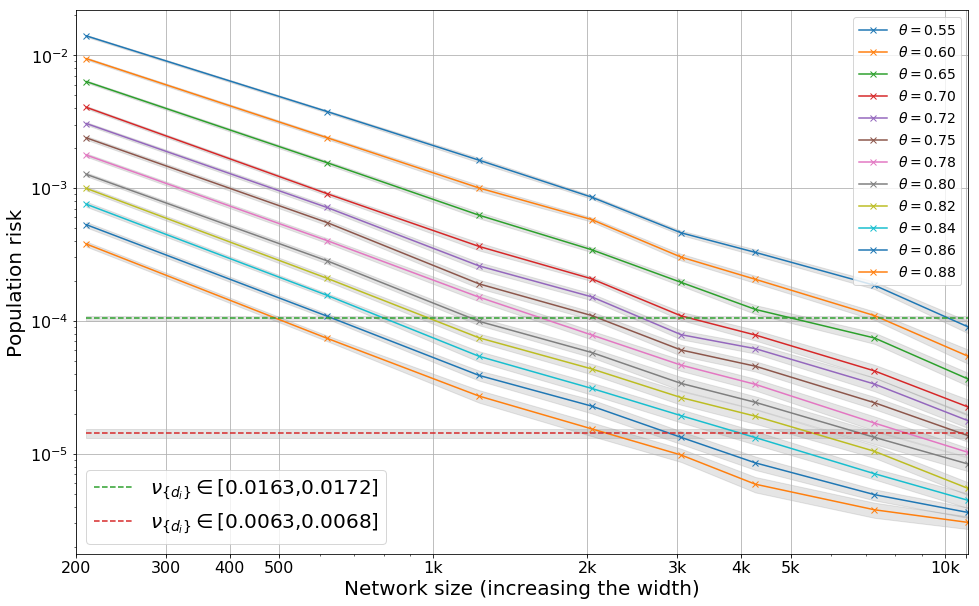

In [21]:
num_iters = len(iters)

excess_risks = np.zeros((num_iters, len(thetas), len(NUM_WIDTH)))

for itr_idx in range(num_iters):
    for theta_idx in range(len(thetas)):
        for width_idx,_ in enumerate(NUM_WIDTH):
            file_name = "page/theta=%.2f/d=%s/rank=%d/noise_level=%.4f/lr=%.2f/iter=%d.npz" %(thetas[theta_idx],ds[width_idx],rk,noise_level,lrs[0],itr_idx)
            data = np.load(file_name)
            risk= data['risk']
            excess_risks[itr_idx,theta_idx,width_idx] = np.min(risk)

excess_risks_std = np.std(excess_risks,0)/5
excess_risks_avg = np.mean(excess_risks,0)

plt.close()
plt.figure(figsize=(16,10))
for theta_idx in range(len(thetas)):
    plt.plot(net_size,excess_risks_avg[theta_idx,:],marker='x',label=r"$\theta=%.2f$"%thetas[theta_idx])
    plt.fill_between(net_size,excess_risks_avg[theta_idx,:]-excess_risks_std[theta_idx,:],excess_risks_avg[theta_idx,:]+excess_risks_std[theta_idx,:],color='gray', alpha=0.2)
    
plt.legend(loc='upper right', prop={'size': 14})
plt.xlabel('Network size (increasing the width)', fontsize=20)
plt.ylabel('Population risk', fontsize=20)

plt.yscale('log')
plt.xscale('log')
plt.xlim((net_size[0]-.1,net_size[-1]+10))
plt.xticks([200,300,400,500,1000,2000,3000,4000,5000,10000,11000],["200","300","400","500", "1k","2k","3k","4k","5k", "10k"])


# select a few horizontal lines
equal_loss=[[(10,1),(7,2),(5,3),(3,4),(1,6)],[(11,3),(10,4),(9,5),(7,6),(5,7)]]

# chack that they indeed have similar network complexity
curves=[]
for eq in equal_loss:
    acc=0
    min_risk, max_risk = 1e10, -1e10
    nu=[]
    for idx in eq:
        nu.append(sum(net_flow(ds[idx[1]], thetas[idx[0]])))
        acc = acc + excess_risks_avg[idx]
        min_risk = min(min_risk, excess_risks_avg[idx])
        max_risk = max(max_risk, excess_risks_avg[idx])
    nu_min = np.min(nu)
    nu_max = np.max(nu)
    nu_avg = np.mean(nu)
    nu_std = np.std(nu)
    avg = (max_risk+min_risk)/2
    curves += plt.plot(net_size, np.ones(len(net_size))*avg, '--', label=r"$\nu_{\{ d_i \}} \in $[%.4f,%.4f]"%(nu_min,nu_max))
    plt.fill_between(net_size,np.ones(len(net_size))*min_risk,np.ones(len(net_size))*max_risk,color='gray', alpha=0.2)


ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

ax=plt.subplot(111)
from matplotlib.legend import Legend
leg = Legend(ax, curves, [curves[0].get_label(), curves[1].get_label()], loc='lower left', prop={'size': 20})
ax.add_artist(leg);

plt.grid()
plt.savefig("plots/excess_risks_%s.pdf"%d, bbox_inches='tight')
plt.show()